Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
garbage-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Found 1915 files belonging to 2 classes.
Using 1532 files for training.
Found 1915 files belonging to 2 classes.
Using 383 files for validation.
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 582ms/step - accuracy: 0.5472 - loss: 1.7486 - val_accuracy: 0.5457 - val_loss: 0.5967
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 570ms/step - accuracy: 0.7359 - loss: 0.5217 - val_accuracy: 0.7859 - val_loss: 0.4261
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 556ms/step - accuracy: 0.8065 - loss: 0.4201 - val_accuracy: 0.7650 - val_loss: 0.4935
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 555ms/step - accuracy: 0.7942 - loss: 0.4083 - val_accuracy: 0.8251 - val_loss: 0.3449
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 550ms/step - accuracy: 0.8596 - loss: 0.3273 - val_accuracy: 0.7859 - val_loss: 0.4018
Training accuracy: 0.87
Validation accuracy: 0.79
Saved artifact at '/tmp/tmpqtie_e32'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140072447458960: TensorSpec(shape=

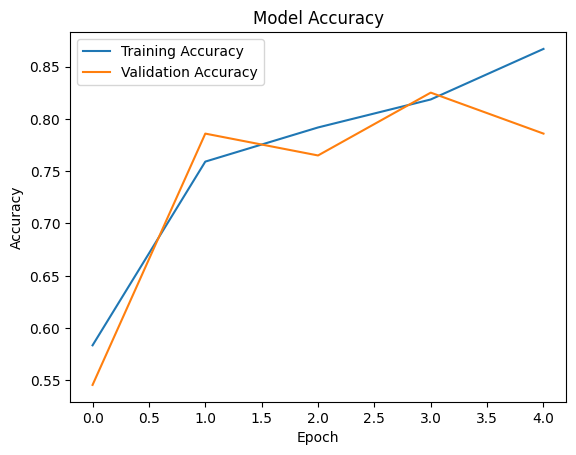

In [3]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import pathlib
import os
import zipfile

# Step 1: Download Garbage Classification dataset from Kaggle
# Install Kaggle API and authenticate
!pip install kaggle
# Upload your kaggle.json file (download from https://www.kaggle.com/settings)
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip dataset
!kaggle datasets download -d mostafaabla/garbage-classification
with zipfile.ZipFile('garbage-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')
data_dir = pathlib.Path('dataset/garbage_classification')

# Step 2: Preprocess images
IMG_HEIGHT, IMG_WIDTH = 150, 150
BATCH_SIZE = 32

# Load images (focusing on plastic and paper for simplicity)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_names=['plastic', 'paper']  # Limit to two classes
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_names=['plastic', 'paper']
)

# Optimize data loading
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Step 3: Build lightweight CNN model
model = models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2)  # 2 classes: plastic, paper
])

# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Step 4: Train model
epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Step 5: Evaluate accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Training accuracy: {train_acc:.2f}")
print(f"Validation accuracy: {val_acc:.2f}")

# Step 6: Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite model
with open('recyclable_classifier.tflite', 'wb') as f:
    f.write(tflite_model)
print("TFLite model saved as recyclable_classifier.tflite")

# Step 7: Test TFLite model on a sample image
interpreter = tf.lite.Interpreter(model_path='recyclable_classifier.tflite')
interpreter.allocate_tensors()

# Get input/output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load a test image (replace with a plastic/paper image from dataset)
test_image_path = 'dataset/garbage_classification/plastic/plastic1.jpg'  # Adjust path
test_image = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

# Run inference
interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
prediction = np.argmax(output_data[0])
print(f"Predicted class: {prediction} (0=plastic, 1=paper)")

# Step 8: Plot training results
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

This quantum circuit uses superposition and entanglement to show how quantum computing can supercharge AI tasks like drug discovery. I built a 2-qubit circuit in Colab using Qiskit applying Hadamard gates to create superposition (qubits representing multiple states at once) and a CNOT gate to entangle them. The output roughly equal counts for ‘00’, ‘01’, ‘10’, and ‘11’ (e.g., ‘11’: 276, ‘10’: 244, ‘00’: 233, ‘01’: 247) shows entanglement worked as measuring one qubit affects the other.
In drug discovery classical AI tests thousands of molecular combinations for drugs, like cancer treatments one by one which can take days. Quantum AI using algorithms like QAOA leverages superposition to evaluate multiple combos at once potentially cutting time to hours. This circuit’s a small demo but it hints at how quantum AI could find the best drug molecules faster. By 2030 this could halve drug discovery time saving costs and lives. Current quantum computers are limited but this shows their future potential for AI tasks.



Found existing installation: qiskit 1.0.0
Uninstalling qiskit-1.0.0:
  Successfully uninstalled qiskit-1.0.0
Found existing installation: qiskit-aer 0.14.2
Uninstalling qiskit-aer-0.14.2:
  Successfully uninstalled qiskit-aer-0.14.2
  Using cached qiskit-1.0.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached qiskit_aer-0.14.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached qiskit-1.0.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.6 MB)
Using cached qiskit_aer-0.14.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)


Measurement outcomes: {'11': 276, '10': 244, '00': 233, '01': 247}


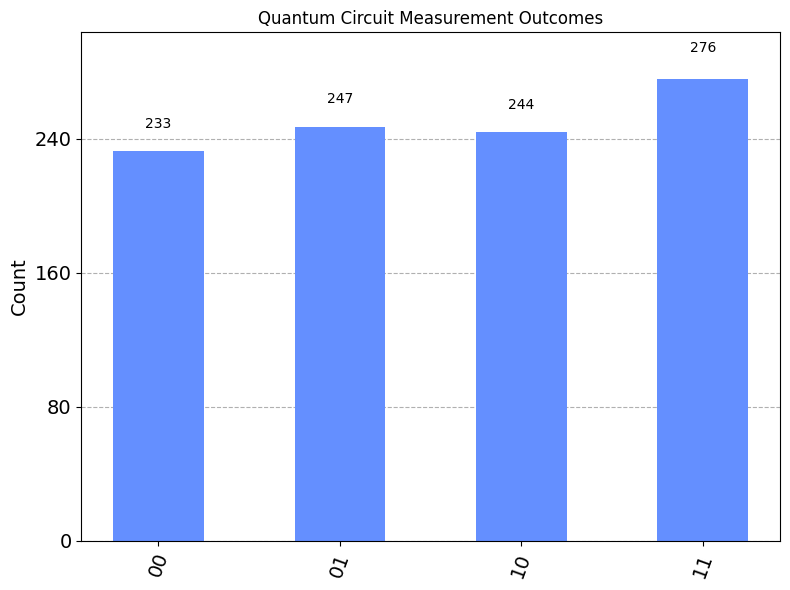

In [4]:

!pip uninstall -y qiskit qiskit-terra qiskit-aer
!pip install qiskit==1.0.0 qiskit-aer==0.14.2

# Step 2: Import libraries
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Step 3: Create a 2-qubit quantum circuit
qc = QuantumCircuit(2, 2)  # 2 qubits 2 classical bits

# Apply Hadamard gates to create superposition
qc.h(0)
qc.h(1)

# Apply CNOT gate for entanglement
qc.cx(0, 1)

# Measure qubits
qc.measure([0, 1], [0, 1])

# Step 4: Simulate circuit using AerSimulator
simulator = AerSimulator()
job = simulator.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()

# Step 5: Print and plot results
print("Measurement outcomes:", counts)

# Create  histogram
fig = plt.figure(figsize=(8, 6))
plot_histogram(counts, ax=plt.gca())
plt.title("Quantum Circuit Measurement Outcomes")
plt.tight_layout()
plt.savefig('histogram.png')
plt.show()